In [1]:
import pandas as pd

In [2]:
from libraries.client_stashapp import get_stashapp_client

stash = get_stashapp_client()

d Using stash (v0.25.1-0) endpoint at http://fraktal.auvilankuja.fi:9999/graphql


In [5]:
def get_parent_studio_id(studio):
    if studio["parent_studio"] is not None:
        return studio["parent_studio"]["id"]
    return None

studios = stash.find_studios({})
df_studios = pd.DataFrame(studios)
df_studios["parent_studio_id"] = df_studios.apply(get_parent_studio_id, axis=1)

In [6]:
performers = stash.find_performers({})
df_performers = pd.DataFrame(performers)


In [7]:
# Lookup functions
def get_by_parent_studio(parent_studio_id):
    return df_studios[df_studios["parent_studio_id"] == parent_studio_id]

def get_studio(studio_id):
    return df_studios[df_studios["id"] == studio_id]

def get_performer(performer_id):
    return df_performers[df_performers["id"] == performer_id]

In [8]:
current_studios = get_by_parent_studio("212")
# current_studios = get_studio("157")
current_studio_ids = current_studios["id"].to_list()

current_studios

,id,name,url,parent_studio,child_studios,aliases,ignore_auto_tag,image_path,scene_count,image_count,gallery_count,performer_count,movie_count,stash_ids,rating100,details,created_at,updated_at,movies,parent_studio_id
115,18,Blacked,https://www.blacked.com/,{'id': '212'},[],[],False,http://fraktal.auvilankuja.fi:9999/studio/18/i...,210,0,2,173,0,"[{'endpoint': 'https://stashdb.org/graphql', '...",NaN,,2023-01-26T08:46:17Z,2024-04-21T11:17:29Z,[],212
116,121,Blacked Raw,https://www.blackedraw.com/,{'id': '212'},[],[],False,http://fraktal.auvilankuja.fi:9999/studio/121/...,64,0,0,82,0,"[{'endpoint': 'https://stashdb.org/graphql', '...",NaN,,2023-01-30T11:46:16Z,2024-04-21T11:17:47Z,[],212
205,95,Deeper,https://www.deeper.com/,{'id': '212'},[],[],False,http://fraktal.auvilankuja.fi:9999/studio/95/i...,182,0,0,130,0,"[{'endpoint': 'https://stashdb.org/graphql', '...",NaN,,2023-01-30T04:51:13Z,2024-04-21T11:17:43Z,[],212
504,214,Milfy,https://www.milfy.com/,{'id': '212'},[],[],False,http://fraktal.auvilankuja.fi:9999/studio/214/...,9,0,0,15,0,"[{'endpoint': 'https://stashdb.org/graphql', '...",NaN,,2024-01-16T09:10:52Z,2024-04-21T11:18:04Z,[],212
720,171,Slayed,https://www.slayed.com/,{'id': '212'},[],[],False,http://fraktal.auvilankuja.fi:9999/studio/171/...,48,0,0,54,0,"[{'endpoint': 'https://stashdb.org/graphql', '...",NaN,,2023-02-06T08:34:06Z,2024-04-21T11:17:57Z,[],212
818,115,Tushy,https://www.tushy.com/,{'id': '212'},[],[],False,http://fraktal.auvilankuja.fi:9999/studio/115/...,187,0,0,173,0,"[{'endpoint': 'https://stashdb.org/graphql', '...",NaN,,2023-01-30T05:06:46Z,2024-04-21T11:17:47Z,[],212
819,213,Tushy Raw,https://www.tushyraw.com/,{'id': '212'},[],[],False,http://fraktal.auvilankuja.fi:9999/studio/213/...,41,0,0,59,0,"[{'endpoint': 'https://stashdb.org/graphql', '...",NaN,,2024-01-16T05:46:50Z,2024-04-21T11:18:04Z,[],212
845,77,Vixen,https://www.vixen.com/,{'id': '212'},[],[],False,http://fraktal.auvilankuja.fi:9999/studio/77/i...,231,0,1,171,0,"[{'endpoint': 'https://stashdb.org/graphql', '...",NaN,,2023-01-29T10:50:54Z,2024-04-21T11:17:40Z,[],212
847,774,Vixen Media Group - Behind The Scenes,https://members.vixen.com/channels/behind-the-...,{'id': '212'},[],[],False,http://fraktal.auvilankuja.fi:9999/studio/774/...,3,0,0,4,0,"[{'endpoint': 'https://stashdb.org/graphql', '...",NaN,,2024-02-29T03:58:17Z,2024-04-21T11:19:30Z,[],212
848,170,Vixen Media Group - Intimates,https://members.vixen.com/channels/intimates,{'id': '212'},[],[],False,http://fraktal.auvilankuja.fi:9999/studio/170/...,1,0,0,1,0,"[{'endpoint': 'https://stashdb.org/graphql', '...",NaN,,2023-02-06T08:07:58Z,2024-04-21T11:17:56Z,[],212


In [37]:
# Find scenes with specific title
# scenes_data = stash.find_scenes({ "title": { "value": "sucker", "modifier": "INCLUDES" } }, filter={ "per_page": 40, "page": 1, "sort": "date", "direction": "DESC" })
# scenes_data = stash.find_scenes({ "performers": { "value": ["210"], "excludes": [], "modifier": "INCLUDES_ALL" } }, filter={ "per_page": 120, "page": 6, "sort": "path", "direction": "DESC" })
scenes_data = stash.find_scenes({
    "studios": { "value": current_studio_ids, "excludes": [], "modifier": "INCLUDES" },
    "stash_id_endpoint": { "endpoint": "", "stash_id": "", "modifier": "NOT_NULL" },
}, filter={ "per_page": 1000, "page": 1, "sort": "path", "direction": "DESC" })
scenes_df = pd.DataFrame(scenes_data)
print(len(scenes_df))

476


In [38]:
def get_path(files):
    return files[0]["path"] if files else None

def get_basename(files):
    return files[0]["basename"] if files else None

def get_first_file_resolution(files):
    return str(files[0]["width"]) + "x" + str(files[0]["height"]) if files else None

def get_studio_value(studio):
    if (studio is None):
        return "Unknown Studio"

    stash_studio = get_studio(studio["id"])
    if stash_studio.empty:
        return "Unknown Studio"
    
    parent_stash_studio = get_studio(stash_studio["parent_studio_id"].iloc[0])
    if not parent_stash_studio.empty:
        return parent_stash_studio["name"].iloc[0] + "꞉ " + stash_studio["name"].iloc[0]

    return stash_studio["name"].iloc[0]


def get_performers(performers):
    if len(performers) == 0:
        return "Unknown performers"

    stash_performers = []
    for performer in performers:
        stash_performer = get_performer(performer["id"])
        if not stash_performer.empty:
            stash_performers.append(stash_performer)
        else:
            raise "Performer not found with ID: " + performer["id"]
    
    # Concatenate the data frames into a single data frame
    df_stash_performers = pd.concat(stash_performers)

    # Sort by gender with a custom order and then by name
    # Define a custom sort order for gender
    gender_priority = {
        'TRANSGENDER_FEMALE': 1,
        'FEMALE': 2,
        'MALE': 3
    }
    
    # Map the 'gender' column to these priorities
    df_stash_performers['gender_priority'] = df_stash_performers['gender'].map(gender_priority).fillna(4)  # Any undefined genders get a default value

    # Now sort by this priority, and then by name
    
    df_stash_performers.sort_values(by=['gender_priority', 'name'], inplace=True)
    
    # Cleanup: remove the auxiliary 'gender_priority' column if no longer needed
    df_stash_performers.drop('gender_priority', axis=1, inplace=True)

    # Return a comma-separated string of names
    return ', '.join(df_stash_performers['name'])

# Define a function to get the first file if available
def get_suffix(files):
    first_file = files[0]["basename"] if files else None
    file_suffix = os.path.splitext(first_file)[1] if first_file else None
    return file_suffix

def title_case_except_acronyms(text):
    words = text.split()
    title_cased_words = []
    for word in words:
        # Check if the word contains an apostrophe
        if "'" in word:
            # Split the word at the apostrophe and process each part
            parts = word.split("'")
            new_parts = [parts[0].title()]  # Always capitalize the part before the apostrophe
            if len(parts) > 1:
                # Never capitalize after the apostrophe
                new_parts.append(parts[1])
            # Rejoin the parts with an apostrophe
            title_cased_words.append("'".join(new_parts))
        else:
            # Apply the original logic if there's no apostrophe
            title_cased_words.append(word if word.isupper() and len(word) > 1 else word.title())

    return ' '.join(title_cased_words)

def clean_title(title):
    title = title_case_except_acronyms(title)
    return title.replace(":", "꞉").replace("?", "？").replace("/", "∕").replace("\\", "＼").replace("*", "＊").replace("\"", "＂").replace("<", "＜").replace(">", "＞").replace("|", "｜").replace("  ", " ")

import os
import re

def convert_stash_path_to_windows_path(files):
    # Check if files is not empty and contains a dictionary with a "path" key
    if not files or "path" not in files[0]:
        return None
    
    path = files[0]["path"]
    if path:
        # Try to extract the drive letter from the path using a regex
        match = re.search(r'/videos_(\w)/', path)
        if match:
            drive_letter = match.group(1).upper()
            # Replace '/videos_x/' with 'X:\' using the drive letter extracted
            path = re.sub(r'/videos_\w/', drive_letter + ':\\\\Culture\\\\Videos\\\\', path)
            # Normalize the path to use backslashes instead of forward slashes
            path = os.path.normpath(path)
        else:
            return None  # Return None if no matching pattern is found
    return path

# Apply the function to the 'files' column
scenes_df['path'] = scenes_df['files'].apply(get_basename)
scenes_df['windows_path'] = scenes_df['files'].apply(convert_stash_path_to_windows_path)
scenes_df['windows_directory'] = scenes_df['files'].apply(lambda files: os.path.dirname(convert_stash_path_to_windows_path(files)))
scenes_df['basename'] = scenes_df['files'].apply(get_basename)
scenes_df['resolution'] = scenes_df['files'].apply(get_first_file_resolution)
scenes_df['primary_studio'] = scenes_df['studio'].apply(get_studio_value)
scenes_df['performers_str'] = scenes_df['performers'].apply(get_performers)
scenes_df['suffix'] = scenes_df['files'].apply(get_suffix)


In [39]:
import pandas as pd
import requests


url = f"http://localhost:33333/api/files?status=both"
response = requests.get(url)
laputin_files = response.json()
df_laputin_files = pd.DataFrame(laputin_files)
df_laputin_files['xxhash'] = df_laputin_files['metadata'].apply(
    lambda x: x.get('hashes', {}).get('xxhash') if x else None
)
df_laputin_files = df_laputin_files.drop_duplicates(subset="path")

scenes_df['windows_path'].notnull().all()
scenes_df["xxhash"] = scenes_df["windows_path"].map(df_laputin_files.set_index("path")["xxhash"])

In [40]:
scenes_df[scenes_df["xxhash"].isnull()]

,id,title,code,details,director,urls,date,rating100,organized,o_counter,...,sceneStreams,path,windows_path,windows_directory,basename,resolution,primary_studio,performers_str,suffix,xxhash
473,7295,Tori Black - Behind The Scenes,101655,"The making of ""Whoever Blinks First"".",,[https://members.tushy.com/channels/behind-the...,2020-05-26,None,False,0,...,[{'url': 'http://fraktal.auvilankuja.fi:9999/s...,Vixen Media Group꞉ Vixen Media Group - Behind ...,Y:\Culture\Videos\Behind The Scenes\Vixen Medi...,Y:\Culture\Videos\Behind The Scenes,Vixen Media Group꞉ Vixen Media Group - Behind ...,3840x2160,Vixen Media Group꞉ Vixen Media Group - Behind ...,Tori Black,.mp4,NaN
474,9415,Ariana Marie & Emily Willis - Behind The Scenes,101653,"The making of ""Pushed in The Right Direction"".",,[https://members.vixen.com/channels/behind-the...,2020-05-24,None,False,0,...,[{'url': 'http://fraktal.auvilankuja.fi:9999/s...,Vixen Media Group꞉ Vixen Media Group - Behind ...,Y:\Culture\Videos\Behind The Scenes\Vixen Medi...,Y:\Culture\Videos\Behind The Scenes,Vixen Media Group꞉ Vixen Media Group - Behind ...,3840x2160,Vixen Media Group꞉ Vixen Media Group - Behind ...,"Ariana Marie, Emily Willis",.mp4,NaN
475,9414,Karla Kush - Behind The Scenes,101651,"Behind the Scenes of ""Blacked Inc. 2""Bla",,[https://members.blacked.com/channels/behind-t...,2020-05-23,None,False,0,...,[{'url': 'http://fraktal.auvilankuja.fi:9999/s...,Vixen Media Group꞉ Vixen Media Group - Behind ...,Y:\Culture\Videos\Behind The Scenes\Vixen Medi...,Y:\Culture\Videos\Behind The Scenes,Vixen Media Group꞉ Vixen Media Group - Behind ...,3840x2160,Vixen Media Group꞉ Vixen Media Group - Behind ...,Karla Kush,.mp4,NaN


In [41]:
scenes_df = scenes_df[scenes_df["xxhash"].isnull()]
scenes_df['fs_title'] = scenes_df['title'].apply(clean_title)
# With studio code
# scenes_df['new_filename'] = scenes_df['primary_studio'] + ' – ' + scenes_df['date'] + ' – ' + scenes_df['code'] + ' – ' + scenes_df['fs_title'] + ' – ' + scenes_df['performers_str'] + ' [' + scenes_df['xxhash'] + ']' + scenes_df['suffix']
# Without studio code
scenes_df['new_filename'] = scenes_df['primary_studio'] + ' – ' + scenes_df['date'] + ' – ' + scenes_df['fs_title'] + ' – ' + scenes_df['performers_str'] + ' [' + scenes_df['xxhash'] + ']' + scenes_df['suffix']
scenes_df['new_path'] = scenes_df['windows_directory'] + '\\' + scenes_df['new_filename']

renames_df = scenes_df[['windows_path', 'new_path', 'xxhash']][scenes_df['windows_path'] != scenes_df['new_path']].sort_values(by='windows_path')
renames_df["new_path"].values

array([nan, nan, nan], dtype=object)

In [36]:
import os
import shutil

for index, row in renames_df.iterrows():
    old_path = row['windows_path']
    new_path = row['new_path']

    if (row['xxhash'] is None):
        print(f"XXHash not found for {old_path}")
        continue
    if (row['new_path'] is None):
        print(f"New path not found for {old_path}")
        continue

    if not pd.isna(new_path) and os.path.isfile(old_path):
        if not os.path.exists(new_path):
            try:
                shutil.move(old_path, new_path)
                print(f"Moved file from {old_path} to {new_path}")
            except Exception as e:
                print(f"Failed to move file from {old_path} to {new_path}: {e}")
        else:
            print(f"A file already exists in the new path: {new_path}")


Moved file from Y:\Culture\Videos\Sites\Vixen Media Group\Slayed\Vixen Media Group꞉ Slayed – 2021-11-18 – 103078 – Vanity – Freya Parker, Skye Blue [07185085b7a57d1f].mp4 to Y:\Culture\Videos\Sites\Vixen Media Group\Slayed\Vixen Media Group꞉ Slayed – 2021-11-18 – Vanity – Freya Parker, Skye Blue [07185085b7a57d1f].mp4


Non-renaming things start from here.

In [46]:
# Find female performers
female_performers = stash.find_performers({ "gender": { "value": "FEMALE", "modifier": "EQUALS" } })
df_female_performers = pd.DataFrame(female_performers)
df_female_performers['birthdate'] = pd.to_datetime(df_female_performers['birthdate'])

In [47]:
favorite_performers = stash.find_performers({ "filter_favorites": True })
df_favorite_performers = pd.DataFrame(favorite_performers)
df_favorite_performers['birthdate'] = pd.to_datetime(df_favorite_performers['birthdate'])

In [48]:
from IPython.display import Image
from IPython.display import display

# Assuming df is your DataFrame and 'image_path' is your column with URLs
x = Image(url= df_favorite_performers['image_path'][0]) 
display(x)

In [33]:
%pip install matplotlib

     ---------------------------------------- 0.0/162.2 kB ? eta -:--:--
     -- ------------------------------------- 10.2/162.2 kB ? eta -:--:--
     -------------- ------------------------ 61.4/162.2 kB 1.1 MB/s eta 0:00:01
     -------------------------------------- 162.2/162.2 kB 1.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/7.6 MB ? eta -:--:--
   ---- ----------------------------------- 0.9/7.6 MB 29.7 MB/s eta 0:00:01
   ------------ --------------------------- 2.4/7.6 MB 37.7 MB/s eta 0:00:01
   ------------------- -------------------- 3.8/7.6 MB 40.1 MB/s eta 0:00:01
   --------------------------- ------------ 5.2/7.6 MB 36.7 MB/s eta 0:00:01
   ---------------------------------- ----- 6.7/7.6 MB 38.8 MB/s eta 0:00:01
   ---------------------------------------  7.6/7.6 MB 37.6 MB/s eta 0:00:01
   ---------------------------------------- 7.6/7.6 MB 34.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/187.7 kB ? eta -:--:--
   -----------

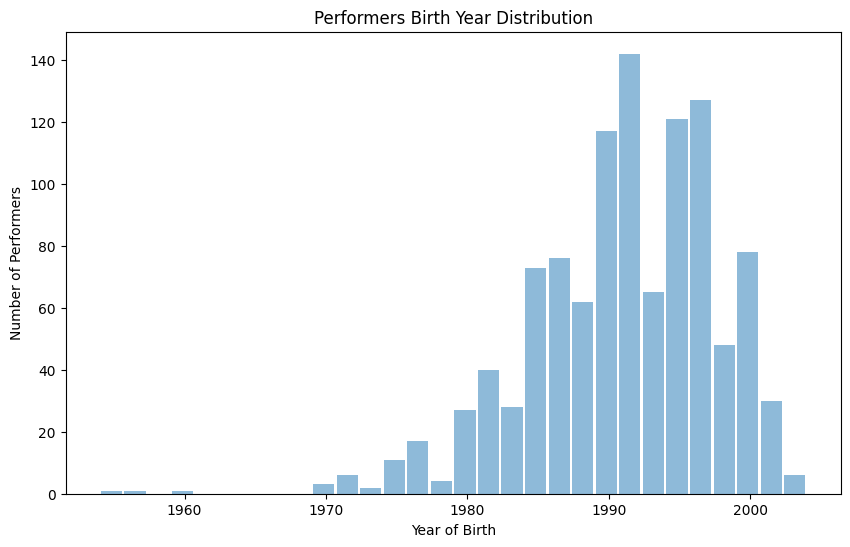

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
df_female_performers['birthdate'].dt.year.hist(bins=30, alpha=0.5, rwidth=0.9)
plt.xlabel('Year of Birth')
plt.ylabel('Number of Performers')
plt.title('Performers Birth Year Distribution')
plt.grid(False)
plt.show()

In [ ]:
# Find scenes with specific performer
scenes_data = stash.find_scenes({ "title": { "value": "erections", "modifier": "INCLUDES" } }, filter={ "per_page": 40, "page": 1, "sort": "date", "direction": "DESC" })
scenes_df = pd.DataFrame(scenes_data)